In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle
import sys
import os
sys.path.insert(0, os.path.abspath('../'))
import jobs

# standardize plot
def standardize(size=(10, 5)):
  plt.gcf().set_size_inches(*size)
  plt.grid(True)
  # set dpi
  plt.gcf().set_dpi(100)
  # set font
  plt.rcParams.update({'font.size': 12})

In [3]:
# read a log file
def read_logfile(logfile):
  with open(logfile, "rb") as f:
    logs = pickle.load(f)
  print(f"Reading from {logfile}")
  # print(f"logs.keys(): {logs.keys()}")
  # print(f"logs['solver_stats'].keys(): {logs['solver_stats'][0].keys()}")
  # extract stats
  data = {}
  data["num_vars"] = np.asarray([x['num_vars'] for x in logs['solver_stats']])
  data["solve_time_ms"] = np.asarray([x['solve_time_ms'] for x in logs['solver_stats']])
  data["setup_time_ms"] = np.asarray([x['setup_time_ms'] for x in logs['solver_stats']])
  data["obj_val"] = np.asarray([x['objective_val'] for x in logs['solver_stats']])
  data["times_min"] = np.asarray([x['time']/60 for x in logs['solver_stats']])
  data["num_jobs"] = np.asarray([x['num_jobs'] for x in logs['solver_stats']])
  return data

In [5]:
# read data for cold starts
prefix = "/home/sauce/data/solvers/logs/cold_start_40kjobs_8kgpus"
solver_logfiles = {
  "CBC" : f"{prefix}/cbc_rtol1e-2_lprelaxed_60s/workload-1.pkl",
  "HiGHS-DS": f"{prefix}/highs-ds_rtol1e-3_lprelaxed_60s/workload-1.pkl",
  "HiGHS-IPM": f"{prefix}/highs-ipm_rtol1e-3_lprelaxed_60s/workload-1.pkl",
  "PIQP": f"{prefix}/piqp_rtol1e-3_lprelaxed_60s/workload-1.pkl",
  "PROXQP": f"{prefix}/proxqp_rtol1e-4_lprelaxed_60s/workload-1.pkl",
  "SCS": f"{prefix}/scs_rtol1e-4_lprelaxed_60s/workload-1.pkl"
}
cold_solver_data = {
  solver: read_logfile(logfile) for solver, logfile in solver_logfiles.items()
}

Reading from /home/sauce/data/solvers/logs/cold_start_40kjobs_8kgpus/cbc_rtol1e-2_lprelaxed_60s/workload-1.pkl
Reading from /home/sauce/data/solvers/logs/cold_start_40kjobs_8kgpus/highs-ds_rtol1e-3_lprelaxed_60s/workload-1.pkl
Reading from /home/sauce/data/solvers/logs/cold_start_40kjobs_8kgpus/highs-ipm_rtol1e-3_lprelaxed_60s/workload-1.pkl
Reading from /home/sauce/data/solvers/logs/cold_start_40kjobs_8kgpus/piqp_rtol1e-3_lprelaxed_60s/workload-1.pkl
Reading from /home/sauce/data/solvers/logs/cold_start_40kjobs_8kgpus/proxqp_rtol1e-4_lprelaxed_60s/workload-1.pkl
Reading from /home/sauce/data/solvers/logs/cold_start_40kjobs_8kgpus/scs_rtol1e-4_lprelaxed_60s/workload-1.pkl


In [6]:
# read data for warm starts
prefix = "/home/sauce/data/solvers/logs/warm_start_40kjobs_8kgpus"
solver_logfiles = {
  "PROXQP": f"{prefix}/proxqp_rtol1e-4_lprelaxed_10s/workload-1.pkl",
  "OSQP": f"{prefix}/osqp_rtol1e-4_lprelaxed_10s/workload-1.pkl",
}
warm_solver_data = {
  solver: read_logfile(logfile) for solver, logfile in solver_logfiles.items()
}

Reading from /home/sauce/data/solvers/logs/warm_start_40kjobs_8kgpus/proxqp_rtol1e-4_lprelaxed_10s/workload-1.pkl
Reading from /home/sauce/data/solvers/logs/warm_start_40kjobs_8kgpus/osqp_rtol1e-4_lprelaxed_10s/workload-1.pkl


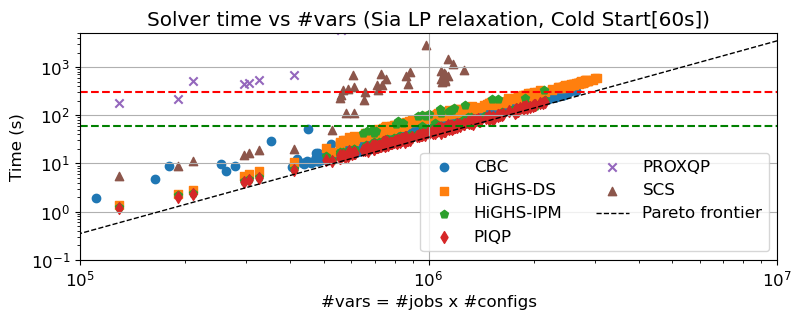

In [21]:
# scatter plot num_vars vs solve_time_ms
markers = {
  "CBC": "o",
  "HiGHS-DS": "s",
  "HiGHS-IPM": "p",
  "PIQP": "d",
  "PROXQP": "x",
  "SCS": "^",
  "OSQP": "v"
}
for solver, data in cold_solver_data.items():
  plt.scatter(data["num_vars"], data["solve_time_ms"]/1000, label=solver, marker=markers[solver])
plt.xlabel("#vars = #jobs x #configs")
plt.ylabel("Time (s)")
plt.title("Solver time vs #vars (Sia LP relaxation, Cold Start[60s])")
standardize(size=(9, 3))
# plot a line: y = mx + c, m=0.01, c=70
x = np.linspace(1e4, 1e7, 20)
y = 0.35*((x/1e5)**2)
plt.plot(x, y, 'k--', linewidth=1, label="Pareto frontier")
plt.yscale("log")
plt.xscale("log")
plt.xlim([1e5, 1e7])
plt.ylim([0.1, 5000])
# get axes
plt.axhline(60, color='g', linestyle='--')
plt.axhline(300, color='r', linestyle='--')
plt.legend(ncol=2)
plt.savefig("figs/cold_start_60s_num_vars_vs_solve_time.jpg", bbox_inches='tight', dpi=300)

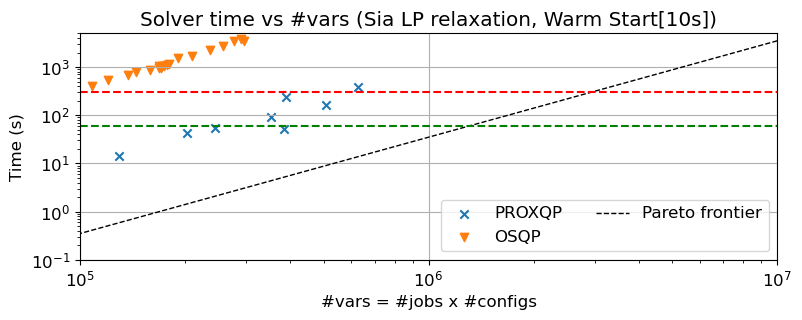

In [22]:
# scatter plot num_vars vs solve_time_ms in warm start mode
markers = {
  "PROXQP": "x",
  "OSQP": "v"
}
for solver, data in warm_solver_data.items():
  plt.scatter(data["num_vars"], data["solve_time_ms"]/1000, label=solver, marker=markers[solver])
plt.xlabel("#vars = #jobs x #configs")
plt.ylabel("Time (s)")
plt.title("Solver time vs #vars (Sia LP relaxation, Warm Start[10s])")
standardize(size=(9, 3))
# plot a line: y = mx + c, m=0.01, c=70
x = np.linspace(1e4, 1e7, 20)
y = 0.35*((x/1e5)**2)
plt.plot(x, y, 'k--', linewidth=1, label="Pareto frontier")
plt.yscale("log")
plt.xscale("log")
plt.xlim([1e5, 1e7])
plt.ylim([0.1, 5000])
# get axes
plt.axhline(60, color='g', linestyle='--')
plt.axhline(300, color='r', linestyle='--')
plt.legend(ncol=2)
plt.savefig("figs/warm_start_10s_num_vars_vs_solve_time.jpg", bbox_inches='tight', dpi=300)